# 🔮 Day 5 - Spell Solutions

In [1]:
knitr::opts_chunk$set(echo = TRUE, warning = FALSE, message = FALSE)
Sys.setlocale("LC_CTYPE", "en_US.UTF-8")

[1] "en_US.UTF-8"

## 🎯 Learning Goals

In this spell, you'll learn to:
- 🔍 Explore magical creature data with visualizations
- 🤖 Build your first KNN (K-Nearest Neighbors) classification model
- 📊 Evaluate model performance with accuracy and confusion matrices
- ⚡ Find the optimal K value for best predictions
- 🔮 Make predictions for new magical creatures

---

## 📚 Load Our Magical Libraries

First, let's load the libraries we need for our machine learning magic!

In [2]:
# Load our magical libraries
library(tidymodels)  # For machine learning magic
library(dplyr)   # For data manipulation and visualization
library(kknn)        # For KNN classification

Warning message:
“package ‘tidymodels’ was built under R version 4.3.3”
Registered S3 method overwritten by 'future':
  method               from      
  all.equal.connection parallelly

── Attaching packages ────────────────────────────────────── tidymodels 1.3.0 ──

✔ broom        1.0.8     ✔ recipes      1.3.1
✔ dials        1.4.0     ✔ rsample      1.3.0
✔ dplyr        1.1.4     ✔ tibble       3.2.1
✔ ggplot2      3.5.2     ✔ tidyr        1.3.1
✔ infer        1.0.7     ✔ tune         1.3.0
✔ modeldata    1.4.0     ✔ workflows    1.2.0
✔ parsnip      1.3.2     ✔ workflowsets 1.1.1
✔ purrr        1.0.4     ✔ yardstick    1.3.2

Warning message:
“package ‘broom’ was built under R version 4.3.3”
Warning message:
“package ‘dials’ was built under R version 4.3.3”
Warning message:
“package ‘scales’ was built under R version 4.3.3”
Warning message:
“package ‘dplyr’ was built under R version 4.3.1”
Warning message:
“package ‘ggplot2’ was built under R version 4.3.3”
Warning message:
“packag

## 📖 Load the Magical Creature Dataset

Oda has been collecting data about various magical creatures she's encountered. Let's see what she's discovered!

In [4]:
# Load the magical creature dataset
# This dataset contains information about various magical creatures Oda has encountered
creatures <- read.csv("../datasets/magical_creatures.csv")

# Take a look at our magical friends
head(creatures)

,creature_id,name,size,magic_power,friendliness_score,behavior
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
1,1,Sparkle Unicorn,7.2,8.5,9.1,friendly
2,2,Shadow Wolf,6.8,7.2,3.4,mischievous
3,3,Rainbow Butterfly,1.5,6.8,8.9,friendly
4,4,Thunder Dragon,9.5,9.8,2.1,mischievous
5,5,Healing Pixie,2.1,7.9,9.5,friendly
6,6,Storm Raven,4.2,8.1,3.8,mischievous


---

## 🔍 Part 1: Exploring the Magical Creature Data

Let's get to know our magical creatures better!

In [5]:
# Let's see what variables we have to work with
# Each creature has: size, magic_power, friendliness_score, and behavior (friendly/mischievous)
glimpse(creatures)

Rows: 100
Columns: 6
$ creature_id        <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, …
$ name               <chr> "Sparkle Unicorn", "Shadow Wolf", "Rainbow Butterfl…
$ size               <dbl> 7.2, 6.8, 1.5, 9.5, 2.1, 4.2, 5.8, 7.9, 1.8, 6.5, 3…
$ magic_power        <dbl> 8.5, 7.2, 6.8, 9.8, 7.9, 8.1, 6.5, 8.7, 5.9, 7.8, 7…
$ friendliness_score <dbl> 9.1, 3.4, 8.9, 2.1, 9.5, 3.8, 8.7, 2.9, 9.2, 3.1, 8…
$ behavior           <chr> "friendly", "mischievous", "friendly", "mischievous…


In [6]:
# How many creatures of each type do we have?
creatures %>%
  count(behavior)

behavior,n
<chr>,<int>
friendly,51
mischievous,49


### 🎨 Visualizing Our Creatures

Let's create a beautiful plot to see if we can spot any patterns!

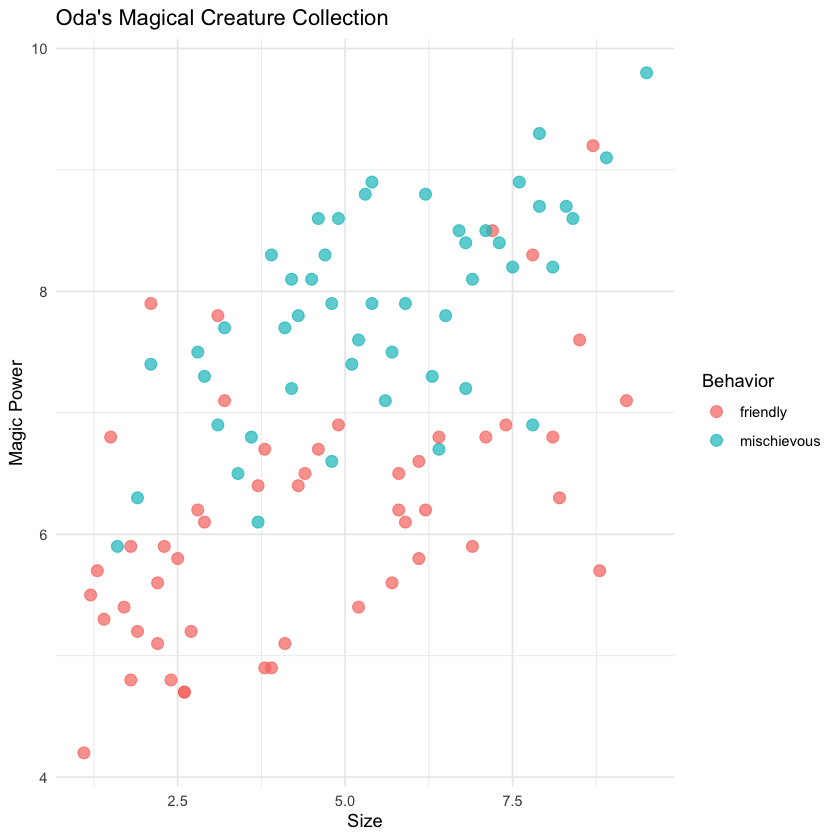

In [7]:
# Let's visualize our creatures!
# Plot size vs magic_power, colored by behavior
ggplot(creatures, aes(x = size, y = magic_power, color = behavior)) +
  geom_point(size = 3, alpha = 0.7) +
  labs(title = "Oda's Magical Creature Collection",
       x = "Size", 
       y = "Magic Power",
       color = "Behavior") +
  theme_minimal()

### 🤔 Think About It!

💡 **Question:** Can you see any patterns? Do friendly creatures tend to cluster together?

---

## ⚙️ Part 2: Setting Up Our KNN Model

Now let's prepare our data for machine learning magic!

### 📊 Split the Data

We need to split our data so we can train our model and then validate how well it works on "new" creatures.

In [8]:
# Split our data into training and validation sets
# We'll use 75% for training, 25% for validation (to choose best K)
set.seed(123)  # For reproducible results

creature_split <- initial_split(creatures, prop = 0.75, strata = behavior)
creature_train <- training(creature_split)
creature_validation <- testing(creature_split)

In [9]:
# Let's check our split worked well
cat("Training data:\n")
creature_train %>% count(behavior)

cat("\nValidation data:\n")
creature_validation %>% count(behavior)

Training data:


behavior,n
<chr>,<int>
friendly,38
mischievous,36



Validation data:


behavior,n
<chr>,<int>
friendly,13
mischievous,13


### 🍳 Create a Recipe for Data Preprocessing

In machine learning, we often need to "cook" our data before feeding it to the model. Here's our recipe!

In [10]:
# Create a recipe for preprocessing our data
# We'll standardize size and magic_power to make sure they're on the same scale
creature_recipe <- recipe(behavior ~ size + magic_power, data = creature_train) %>%
  step_scale(all_predictors()) %>%     # Scale to standard deviation 1
  step_center(all_predictors())        # Center around 0

print("Our magical recipe is ready!")

[1] "Our magical recipe is ready!"


### 🤖 Create Our KNN Model

Now let's create our KNN model. We'll start with K=5 neighbors.

In [11]:
# Create our KNN model specification
# We'll start with K=5 neighbors
knn_model <- nearest_neighbor(neighbors = 5) %>%
  set_engine("kknn") %>%
  set_mode("classification")

print("KNN model created with K=5 neighbors!")

[1] "KNN model created with K=5 neighbors!"


---

## 🎓 Part 3: Training Our KNN Classifier

Time to train our magical creature classifier!

In [12]:
# Create a workflow that combines our recipe and model
creature_workflow <- workflow() %>%
  add_recipe(creature_recipe) %>%
  add_model(knn_model)

print("Workflow assembled - ready for training!")

[1] "Workflow assembled - ready for training!"


In [13]:
# Train our model!
creature_fit <- creature_workflow %>%
  fit(data = creature_train)

print("🎉 Model training complete!")

[1] "🎉 Model training complete!"


In [14]:
# Let's make predictions on our validation data
creature_predictions <- predict(creature_fit, creature_validation) %>%
  bind_cols(creature_validation)

# Look at our predictions
head(creature_predictions)

.pred_class,creature_id,name,size,magic_power,friendliness_score,behavior
<fct>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
mischievous,1,Sparkle Unicorn,7.2,8.5,9.1,friendly
friendly,2,Shadow Wolf,6.8,7.2,3.4,mischievous
mischievous,3,Rainbow Butterfly,1.5,6.8,8.9,friendly
mischievous,6,Storm Raven,4.2,8.1,3.8,mischievous
mischievous,11,Crystal Owl,3.2,7.1,8.4,friendly
mischievous,20,Cave Bat,2.9,7.3,3.5,mischievous


---

## 📈 Part 4: Evaluating Our Magical Predictions

How well did our model do? Let's find out!

### 🎯 Calculate Accuracy

In [15]:
# Calculate the accuracy of our predictions
# Convert to factors for proper classification metrics
creature_predictions_factor <- creature_predictions %>%
  mutate(
    behavior = as.factor(behavior),
    .pred_class = as.factor(.pred_class)
  )

accuracy_result <- creature_predictions_factor %>%
  accuracy(truth = behavior, estimate = .pred_class)

print(paste("Our KNN model accuracy:", round(accuracy_result$.estimate, 3)))

[1] "Our KNN model accuracy: 0.731"


### 📊 Confusion Matrix

A confusion matrix shows us exactly where our model made mistakes.

In [16]:
# Create a confusion matrix to see where we made mistakes
creature_predictions_factor %>%
  conf_mat(truth = behavior, estimate = .pred_class)

             Truth
Prediction    friendly mischievous
  friendly          10           4
  mischievous        3           9

### 🎨 Visualize Predictions vs Reality

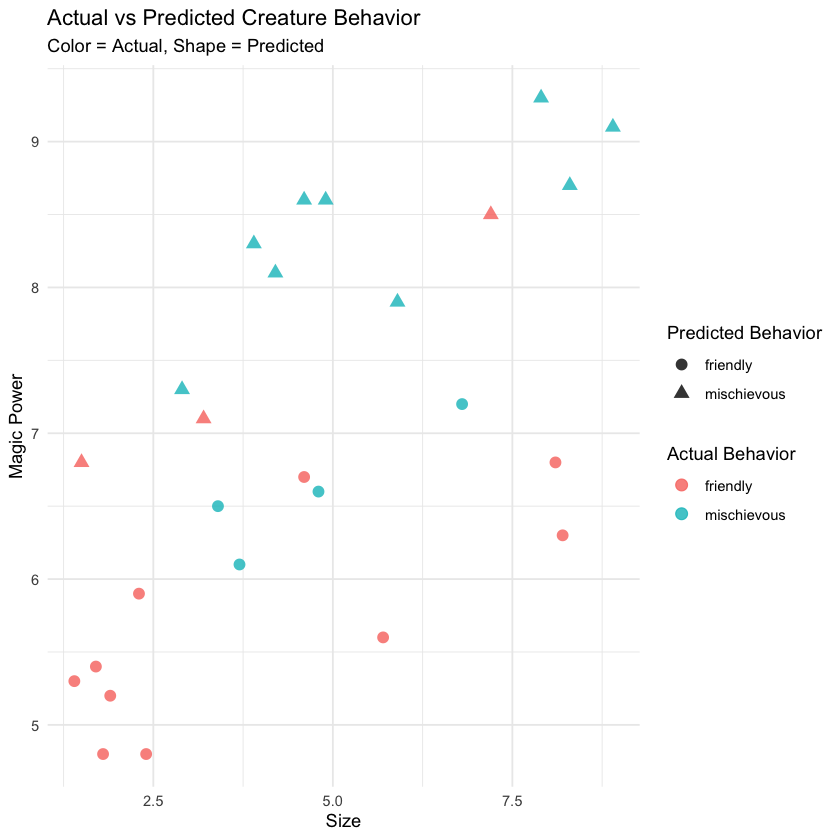

In [17]:
# Visualize our predictions vs actual behavior
ggplot(creature_predictions, aes(x = size, y = magic_power)) +
  geom_point(aes(color = behavior, shape = .pred_class), size = 3, alpha = 0.8) +
  labs(title = "Actual vs Predicted Creature Behavior",
       subtitle = "Color = Actual, Shape = Predicted",
       x = "Size", 
       y = "Magic Power",
       color = "Actual Behavior",
       shape = "Predicted Behavior") +
  theme_minimal()

---

## 🔧 Part 5: Testing Different K Values

Different K values can give us different results. Let's find the best one!

In [18]:
# Let's try different K values to see which works best!
test_k_values <- function(k_val) {
  knn_model_k <- nearest_neighbor(neighbors = k_val) %>%
    set_engine("kknn") %>%
    set_mode("classification")
  
  workflow_k <- workflow() %>%
    add_recipe(creature_recipe) %>%
    add_model(knn_model_k)
  
  fit_k <- workflow_k %>% fit(data = creature_train)
  
  predictions_k <- predict(fit_k, creature_validation) %>%
    bind_cols(creature_validation)
  
  accuracy_k <- predictions_k %>%
    mutate(
      behavior = as.factor(behavior),
      .pred_class = as.factor(.pred_class)
    ) %>%
    accuracy(truth = behavior, estimate = .pred_class) %>%
    pull(.estimate)
  
  return(accuracy_k)
}

In [19]:
# Test different K values
k_values <- c(1, 3, 5, 7, 10)
accuracies <- map_dbl(k_values, test_k_values)

# Create a data frame with results
k_results <- tibble(K = k_values, Accuracy = accuracies)

print("Results for different K values:")
print(k_results)

[1] "Results for different K values:"
# A tibble: 5 × 2
      K Accuracy
  <dbl>    <dbl>
1     1    0.654
2     3    0.654
3     5    0.731
4     7    0.731
5    10    0.769


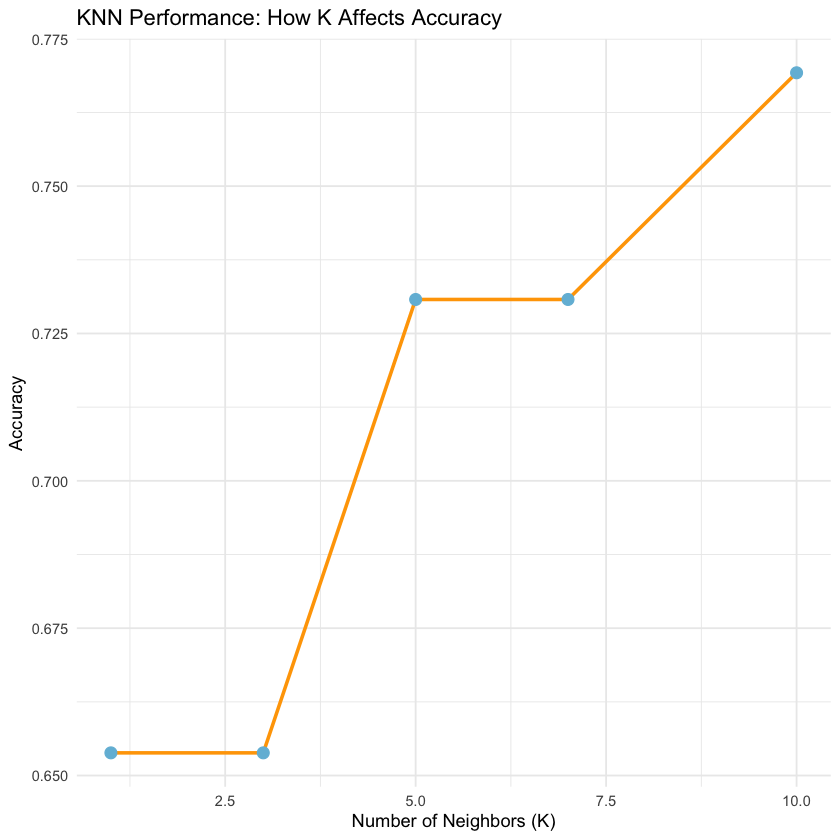

In [20]:
# Plot K vs Accuracy
ggplot(k_results, aes(x = K, y = Accuracy)) +
  geom_line(color = "orange", linewidth = 1) +
  geom_point(color = "#73bbda", size = 3) +
  labs(title = "KNN Performance: How K Affects Accuracy",
       x = "Number of Neighbors (K)",
       y = "Accuracy") +
  theme_minimal()

---

## 🔮 Part 6: Predict New Magical Creatures!

Oda has discovered some new creatures! Can you predict their behavior?

In [21]:
# Oda has discovered some new creatures! Can you predict their behavior?
new_creatures <- tibble(
  name = c("Sparkle Dragon", "Tiny Pixie", "Giant Troll"),
  size = c(8.5, 1.2, 9.8),
  magic_power = c(9.1, 7.8, 3.2)
)

print("New creatures discovered:")
print(new_creatures)

[1] "New creatures discovered:"
# A tibble: 3 × 3
  name            size magic_power
  <chr>          <dbl>       <dbl>
1 Sparkle Dragon   8.5         9.1
2 Tiny Pixie       1.2         7.8
3 Giant Troll      9.8         3.2


In [22]:
# Make predictions for the new creatures
# Use the best K value from your analysis above
best_k <- k_results %>%
  filter(Accuracy == max(Accuracy)) %>%
  pull(K) %>%
  first()

print(paste("Best K value:", best_k))

# Retrain model with best K
best_knn_model <- nearest_neighbor(neighbors = best_k) %>%
  set_engine("kknn") %>%
  set_mode("classification")

best_workflow <- workflow() %>%
  add_recipe(creature_recipe) %>%
  add_model(best_knn_model)

best_fit <- best_workflow %>% fit(data = creature_train)

# Predict behavior for new creatures
new_predictions <- predict(best_fit, new_creatures) %>%
  bind_cols(new_creatures)

print("Predictions for new magical creatures:")
print(new_predictions)

[1] "Best K value: 10"
[1] "Predictions for new magical creatures:"
# A tibble: 3 × 4
  .pred_class name            size magic_power
  <fct>       <chr>          <dbl>       <dbl>
1 mischievous Sparkle Dragon   8.5         9.1
2 mischievous Tiny Pixie       1.2         7.8
3 friendly    Giant Troll      9.8         3.2


---

## 🧪 Part 7: Final Model Testing with Independent Test Set

Now let's test our final model on completely unseen data to get an unbiased performance estimate!

In [24]:
# Load the independent test dataset
# This data was never used for training or choosing K
test_creatures <- read.csv("../datasets/magical_creatures_test.csv")

print("Independent test dataset loaded:")
print(paste("Number of test creatures:", nrow(test_creatures)))
test_creatures %>% count(behavior)

[1] "Independent test dataset loaded:"
[1] "Number of test creatures: 36"


behavior,n
<chr>,<int>
friendly,18
mischievous,18


In [25]:
# Use our best model (with optimal K) to make predictions on test set
final_test_predictions <- predict(best_fit, test_creatures) %>%
  bind_cols(test_creatures)

# Calculate final test accuracy
final_test_accuracy <- final_test_predictions %>%
  mutate(
    behavior = as.factor(behavior),
    .pred_class = as.factor(.pred_class)
  ) %>%
  accuracy(truth = behavior, estimate = .pred_class)

print(paste("🎯 Final Test Accuracy (K =", best_k, "):", round(final_test_accuracy$.estimate, 3)))

[1] "🎯 Final Test Accuracy (K = 10 ): 0.889"


In [26]:
# Final confusion matrix on test set
print("🔍 Final Confusion Matrix on Test Set:")
final_test_predictions %>%
  mutate(
    behavior = as.factor(behavior),
    .pred_class = as.factor(.pred_class)
  ) %>%
  conf_mat(truth = behavior, estimate = .pred_class)

[1] "🔍 Final Confusion Matrix on Test Set:"


             Truth
Prediction    friendly mischievous
  friendly          15           1
  mischievous        3          17

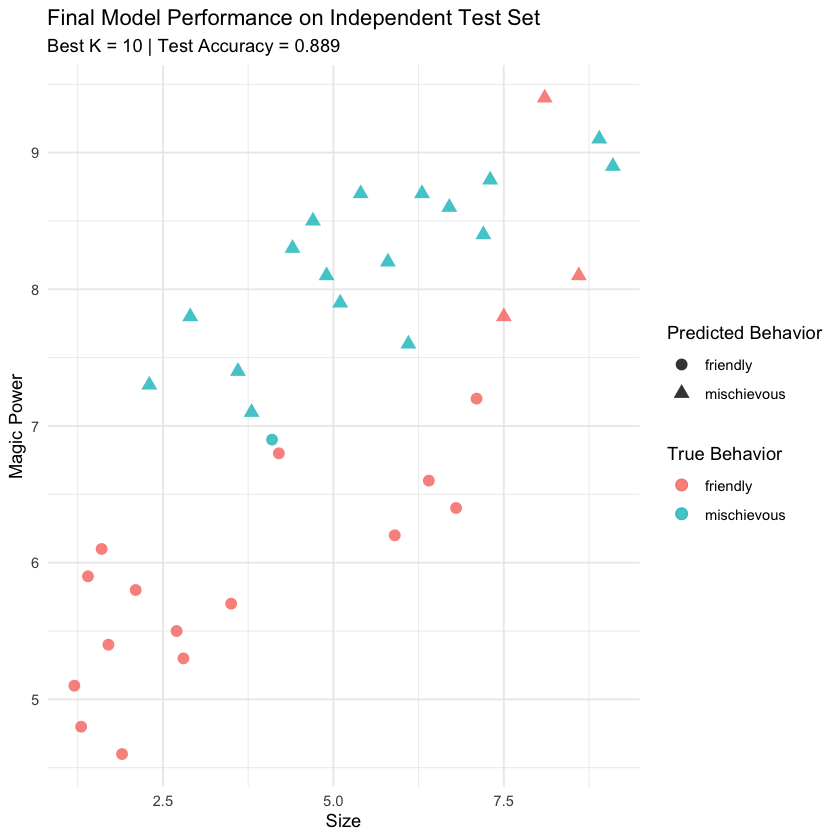

In [27]:
# Visualize final test results
ggplot(final_test_predictions, aes(x = size, y = magic_power)) +
  geom_point(aes(color = behavior, shape = .pred_class), size = 3, alpha = 0.8) +
  labs(title = "Final Model Performance on Independent Test Set",
       subtitle = paste("Best K =", best_k, "| Test Accuracy =", round(final_test_accuracy$.estimate, 3)),
       x = "Size", 
       y = "Magic Power",
       color = "True Behavior",
       shape = "Predicted Behavior") +
  theme_minimal()